<a href="https://www.kaggle.com/code/yoontaewoo/hubmap-eda?scriptVersionId=103583044" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import glob, sys, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings(action = 'ignore')
import pandas as pd
import json
import tensorflow as tf
import tensorflow_io as tfio
import cv2
from tensorflow import image

# 1. Load data

351


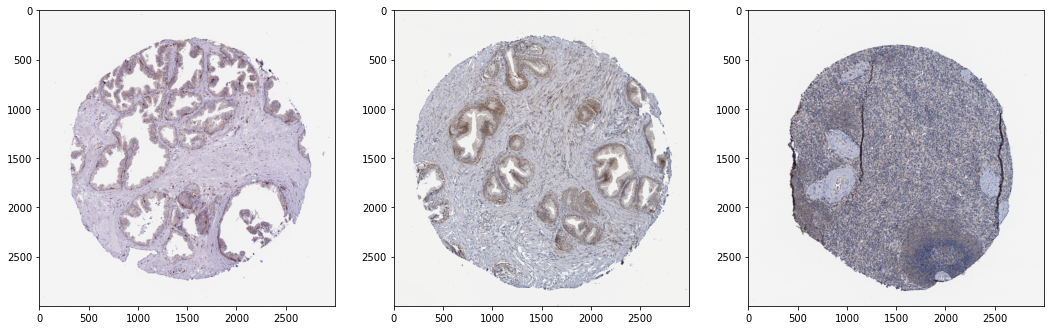

In [2]:
img_paths = sorted(glob.glob('../input/hubmap-organ-segmentation/train_images/*tiff'))
print(len(img_paths))

plt.figure(figsize = (18,10))
for i in range(3) :
    img = Image.open(img_paths[i])
    plt.subplot(1,3,i+1)
    plt.imshow(img)
plt.show()

In [3]:
df = pd.read_csv('../input/hubmap-organ-segmentation/train.csv')
print(df.shape)
df.head(3)

(351, 10)


,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male


## organ(장기)
* prostate : 전립선
* spleen : 비장
* lung : 폐
* kidney : 신장
* largeintestine : 대장

## rle : run lengh encoding

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                351 non-null    int64  
 1   organ             351 non-null    object 
 2   data_source       351 non-null    object 
 3   img_height        351 non-null    int64  
 4   img_width         351 non-null    int64  
 5   pixel_size        351 non-null    float64
 6   tissue_thickness  351 non-null    int64  
 7   rle               351 non-null    object 
 8   age               351 non-null    float64
 9   sex               351 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 27.5+ KB


# 2.Visualization

['prostate' 'spleen' 'lung' 'kidney' 'largeintestine']


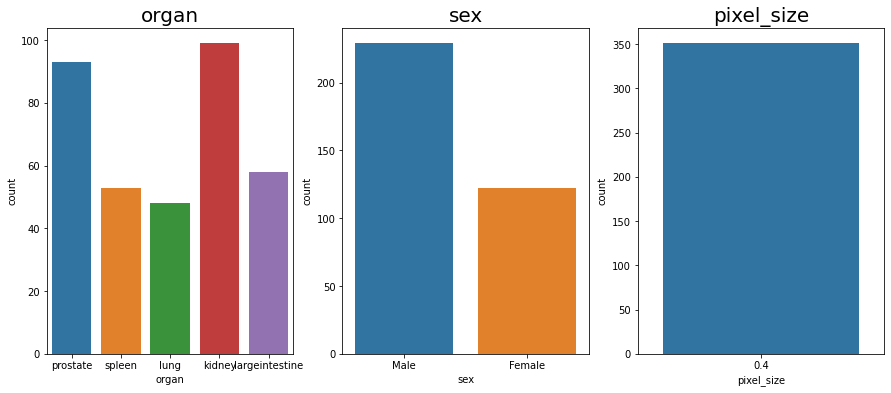

In [5]:
print(df['organ'].unique())

columns = ['organ', 'sex', 'pixel_size']
plt.figure(figsize = (15,6))
for i,col in enumerate(columns) :
    plt.subplot(1,3,i+1)
    sns.countplot(df[col])
    plt.title(col, size = 20)
plt.show()

(229, 10) (122, 10)


Text(0.5, 1.0, 'Organ distribution according to sex')

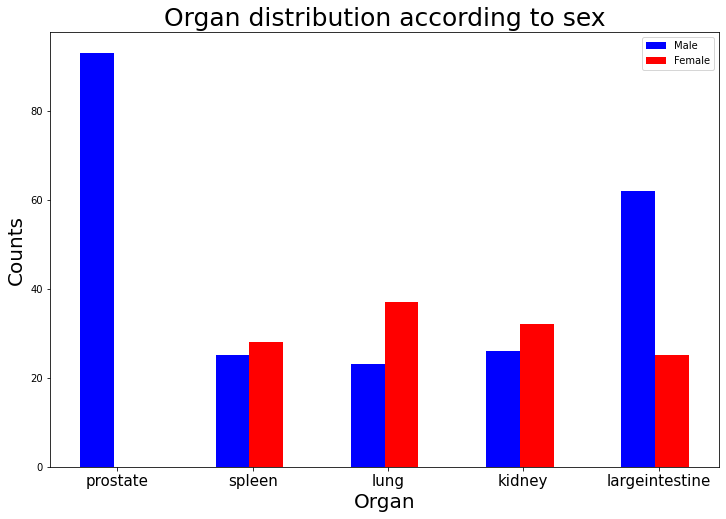

In [6]:
m = df[df['sex'] == 'Male']
m_count = []
for i in m['organ'].unique() :
    a = m[m['organ'] == i]
    m_count.append(len(a))
f = df[df['sex'] == 'Female']
f_count = [0]
for i in f['organ'].unique() :
    a = f[f['organ'] == i]
    f_count.append(len(a))
print(m.shape,f.shape)

fig = plt.figure(figsize=(12, 8))
idx = np.arange(1,10,2)
plt.bar(idx+1.7, m_count, color = 'blue', width = 0.5, label = 'Male')
plt.bar(idx+2.2, f_count, color = 'red', width = 0.5, label = 'Female')
plt.xticks(idx+2, df['organ'].unique(), size = 15)
plt.legend()
plt.xlabel('Organ', size = 20)
plt.ylabel('Counts', size = 20)
plt.title('Organ distribution according to sex', size = 25)

<AxesSubplot:xlabel='img_width', ylabel='img_height'>

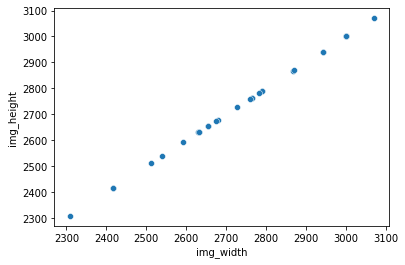

In [7]:
sns.scatterplot(df['img_width'], df['img_height'], )

In [8]:
# images shape
shape = []
for i in range(len(df)):
    s = (df['img_width'][i], df['img_height'][i])
    shape.append(s)
print(set(shape))

{(2867, 2867), (2539, 2539), (2869, 2869), (2630, 2630), (2675, 2675), (2764, 2764), (2631, 2631), (2680, 2680), (3000, 3000), (2308, 2308), (2942, 2942), (3070, 3070), (2511, 2511), (2416, 2416), (2790, 2790), (2727, 2727), (2760, 2760), (2654, 2654), (2593, 2593), (2783, 2783)}


In [9]:
print(df['tissue_thickness'].unique(), df['data_source'].unique())

[4] ['HPA']


['../input/hubmap-organ-segmentation/test_images/10078.tiff']
(2023, 2023, 3)


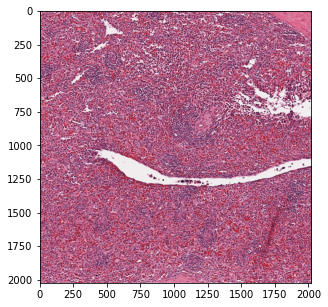

In [10]:
test_path = glob.glob('../input/hubmap-organ-segmentation/test_images/*tiff')
print(test_path)
test_img = Image.open(test_path[0])
test_img = np.array(test_img)
print(test_img.shape)
plt.figure(figsize = (15,5))
plt.imshow(test_img)

In [11]:
df_test = pd.read_csv('../input/hubmap-organ-segmentation/test.csv')
print(df_test)
df_sub = pd.read_csv('../input/hubmap-organ-segmentation/sample_submission.csv')
df_sub

      id   organ data_source  img_height  img_width  pixel_size  \
0  10078  spleen      Hubmap        2023       2023      0.4945   

   tissue_thickness  
0                 4  


,id,rle
0,10078,12 34


In [12]:
# get train_annotations
import json

ann_paths = glob.glob('../input/hubmap-organ-segmentation/train_annotations/*json')
anns = []
for path in ann_paths :
    with open(path) as f:
        ann = json.load(f)
        anns.append(ann)
anns = np.array(anns)
print(len(anns))
anns.shape

351


(351,)

In [13]:
with open(ann_paths[0]) as f :
    a = json.load(f)
len(a)

4

In [14]:
# 시작점과 끝나는점 리턴하는 함수 생성
def Rle_split(rle) :
  n = np.array(rle.split(' '), dtype = int)
  start = n[::2]
  lengths = n[1::2]
  end = start+lengths
  return start,end

# 백지 만들고 mask에 해당하는 부분 그리도록 하는 함수 생성
def Draw(shape, start, end, color) :
  if len(shape) == 3 :
    h,w,c = shape
    white = np.zeros((h*w,c), dtype = np.float32)
  else :
    h,w = shape
    white = np.zeros((h*w), dtype = np.float32)

  for s,e in zip(start,end) :
    white[s:e] = color
  return white.reshape(shape).T

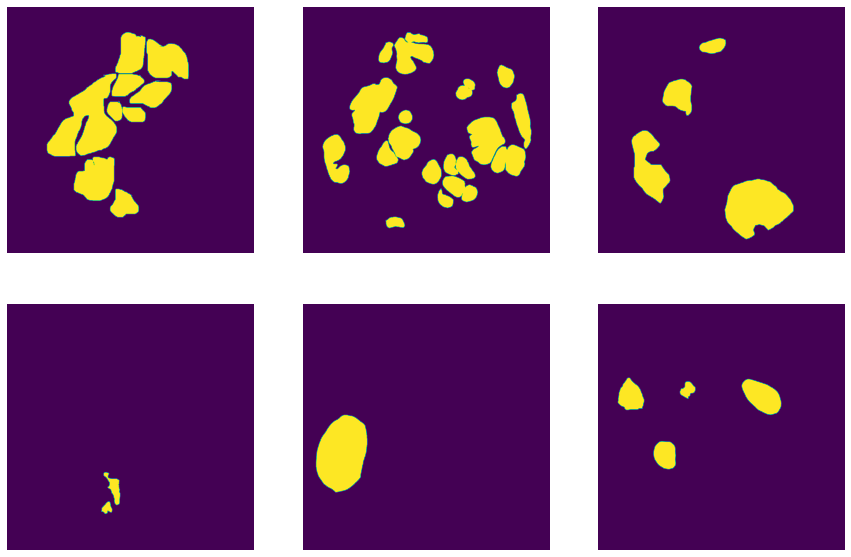

In [15]:
plt.figure(figsize=(15,10))
for i in range(6) :
  rle = df['rle'][i]
  start, end = Rle_split(rle)
  a = Draw((3000,3000), start, end, 1)
  plt.subplot(2,3,i+1)
  # plt.xticks([]);plt.yticks([])
  plt.axis("off")
  plt.imshow(a)